In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsaplots

# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px

from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler


C:\Users\minhh\AppData\Local\Temp\ipykernel_16124\21078125.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
df=pd.read_csv('../Dataset/DXG Historical Data.csv')

In [3]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/02/2023,"15,150.0","15,400.0","15,500.0","15,000.0",20.98M,0.00%
1,06/01/2023,"15,150.0","14,900.0","15,200.0","14,850.0",18.46M,1.68%
2,05/31/2023,"14,900.0","14,950.0","15,200.0","14,850.0",15.10M,-0.33%
3,05/30/2023,"14,950.0","14,950.0","15,200.0","14,750.0",30.20M,2.40%
4,05/29/2023,"14,600.0","14,650.0","14,750.0","14,500.0",13.24M,1.04%
...,...,...,...,...,...,...,...
1366,12/07/2017,"12,100.6","12,161.1","12,312.3","11,858.5",5.23M,-0.50%
1367,12/06/2017,"12,161.1","12,161.1","12,342.6","11,919.0",7.72M,-0.99%
1368,12/05/2017,"12,282.1","12,705.6","12,917.3","12,282.1",11.06M,-3.33%
1369,12/04/2017,"12,705.6","12,463.6","12,705.6","12,282.1",9.42M,3.70%


In [4]:
# Checking null value
df.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [5]:
df.dtypes

Date        object
Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object

In [6]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [7]:
tranformData(df)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-06-02,15150.0,15400.0,15500.0,15000.0,20980000.0,0.0000
1,2023-06-01,15150.0,14900.0,15200.0,14850.0,18460000.0,0.0168
2,2023-05-31,14900.0,14950.0,15200.0,14850.0,15100000.0,-0.0033
3,2023-05-30,14950.0,14950.0,15200.0,14750.0,30200000.0,0.0240
4,2023-05-29,14600.0,14650.0,14750.0,14500.0,13240000.0,0.0104
...,...,...,...,...,...,...,...
1366,2017-12-07,12100.6,12161.1,12312.3,11858.5,5230000.0,-0.0050
1367,2017-12-06,12161.1,12161.1,12342.6,11919.0,7720000.0,-0.0099
1368,2017-12-05,12282.1,12705.6,12917.3,12282.1,11060000.0,-0.0333
1369,2017-12-04,12705.6,12463.6,12705.6,12282.1,9420000.0,0.0370


In [8]:
df=df.sort_values(['Date'], ascending=[True])
df = df.reset_index(drop=True)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2017-12-01,12251.8,11949.3,12403.1,11919.0,8610000.0,0.0279
1,2017-12-04,12705.6,12463.6,12705.6,12282.1,9420000.0,0.0370
2,2017-12-05,12282.1,12705.6,12917.3,12282.1,11060000.0,-0.0333
3,2017-12-06,12161.1,12161.1,12342.6,11919.0,7720000.0,-0.0099
4,2017-12-07,12100.6,12161.1,12312.3,11858.5,5230000.0,-0.0050
...,...,...,...,...,...,...,...
1366,2023-05-29,14600.0,14650.0,14750.0,14500.0,13240000.0,0.0104
1367,2023-05-30,14950.0,14950.0,15200.0,14750.0,30200000.0,0.0240
1368,2023-05-31,14900.0,14950.0,15200.0,14850.0,15100000.0,-0.0033
1369,2023-06-01,15150.0,14900.0,15200.0,14850.0,18460000.0,0.0168


In [9]:
df.describe()

,Price,Open,High,Low,Vol.,Change %
count,1371.000000,1371.000000,1371.000000,1371.000000,1.371000e+03,1371.000000
mean,17674.362509,17660.057695,18070.651058,17290.551860,7.081185e+06,0.000702
std,7590.149172,7578.982544,7806.761118,7367.071153,5.709696e+06,0.032425
min,6739.100000,6269.600000,6947.800000,6269.600000,4.483700e+05,-0.070000
25%,12395.650000,12434.800000,12608.700000,12220.800000,2.750000e+06,-0.016300
50%,16066.500000,16100.000000,16350.000000,15793.000000,5.640000e+06,0.000000
75%,20852.300000,20800.000000,21217.200000,20435.000000,9.835000e+06,0.019600
max,46750.000000,46500.000000,47450.000000,46200.000000,4.930000e+07,0.070000


In [10]:
fig = px.line(df, x=df.Date, y=df.Price,labels={'Date':'Date','Price':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price for chart of DXG', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [11]:
# Tính số lượng mẫu trong tập huấn luyện, tập kiểm tra
train_size = int(len(df) * 0.6)
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

# Chia dữ liệu thành tập huấn luyện, tập kiểm tra
df=df['Price']

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
# In số lượng mẫu trong mỗi tập dữ liệu
print("Số lượng mẫu trong tập huấn luyện: ", train_data.shape)
print("Số lượng mẫu trong tập kiểm tra: ", test_data.shape)
print("Số lượng mẫu trong tập valid: ", val_data.shape)

Số lượng mẫu trong tập huấn luyện:  (822,)
Số lượng mẫu trong tập kiểm tra:  (274,)
Số lượng mẫu trong tập valid:  (275,)


In [12]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# #Test for staionarity
# def test_stationarity(timeseries):
#     #Determing rolling statistics
#     rolmean = timeseries.rolling(12).mean()
#     rolstd = timeseries.rolling(12).std()
#     #Plot rolling statistics:
#     plt.plot(timeseries, color='blue',label='Original')
#     plt.plot(rolmean, color='red', label='Rolling Mean')
#     plt.plot(rolstd, color='black', label = 'Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean and Standard Deviation')
#     plt.show(block=False)
    
#     print("Results of dickey fuller test")
#     adft = adfuller(timeseries,autolag='AIC')
#     # output for dft will give us without defining what the values are.
#     #hence we manually write what values does it explains using a for loop
#     output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
#     for key,values in adft[4].items():
#         output['critical value (%s)'%key] =  values
#     print(output)

In [13]:
# test_stationarity(train_data)

In [14]:
# train_data_diff = train_data.diff().dropna()
# test_stationarity(train_data_diff)

In [15]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# acf_original = plot_acf(train_data_diff)

# pacf_original = plot_pacf(train_data_diff)

In [16]:
from pmdarima.arima import auto_arima
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data)
model=auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
# model = auto_arima(y_train, start_p=0, start_q=0,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=20, max_q=20, # maximum p and q
#                       m=1,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=False, 
#                       stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12320.280, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12322.374, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12322.551, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12322.723, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12320.909, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12323.882, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12324.375, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12321.244, Time=1.01 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=12319.520, Time=1.62 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=12320.877, Time=0.62 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=12322.820, Time=1.23 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=12320.397, Time=1.36 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=12320.825, Time=0.82 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=12320.823, Time=2.84 sec
 ARIMA(2,1,3)(0,0,0

In [17]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data)
y_pred_val =  model.predict(n_periods=len(y_val))

In [18]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[21559.27045064 21379.14940636 21474.5843233  21381.5588527
 21424.99877006 21458.06004382 21418.20082214 21529.23412584
 21412.48586418 21532.175894   21402.74754664 21483.73059968
 21418.44679128 21435.7660865  21464.91172454 21412.56331841
 21507.07098229 21407.52336372 21511.03361485 21414.4472652
 21479.22986902 21436.63582548 21439.61290302 21469.98509993
 21414.90917553 21495.65630718 21410.48687234 21496.01868394
 21422.6691332  21471.86309251]


In [19]:
# last_date=val_data.index[-1]
# forecast_dates = pd.date_range(last_date, periods=30, freq='D')[1:]
# forecast_df = pd.DataFrame([(date, 0) for date in forecast_dates], columns=['Date', 'Close'])

# # Predict the closing prices for the next 30 days
# y_next_30_days = model.predict(n_periods=len(forecast_df))

# # Print the predicted closing prices for the next 30 days
# print('Predicted closing prices for the next 30 days:')
# print(y_next_30_days)

In [20]:
# for i in range(len(forecast_df)):
#     forecast_df.loc[i, 'Close'] = y_next_30_days[i]

In [21]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error


vail_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', vail_mape)
print('Testing MAPE:', test_mape)


Validation RMSE: 7497.461415426206
Testing RMSE: 10317.761737146686
Validation MAPE: 0.4722501707103717
Testing MAPE: 0.20867581620927408


Validation RMSE: 7497.461415426206
Testing RMSE: 10317.761737146686


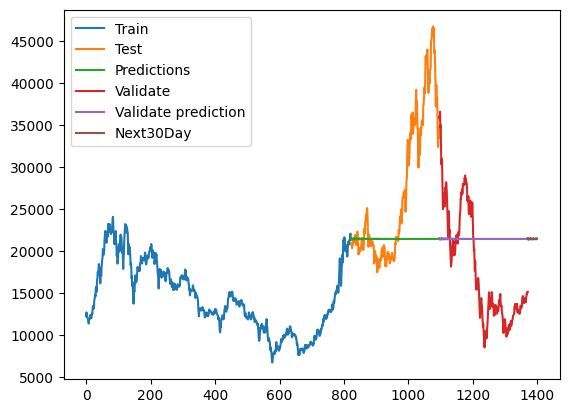

In [22]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Validate prediction','Next30Day'])
plt.show()

In [23]:
x_train = df.index.to_numpy()
y_train = values_array = df.values
model=auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21608.051, Time=3.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21619.764, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21611.031, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21610.413, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21617.779, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21609.563, Time=0.70 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21609.477, Time=1.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=21612.415, Time=1.77 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=21612.388, Time=3.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21608.176, Time=0.66 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=21610.986, Time=0.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=21610.864, Time=1.03 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=21609.711, Time=4.83 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=21606.057, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0

In [24]:
# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[15131.09388006 15176.67827676 15177.61871252 15206.94575001
 15215.90416517 15237.15283147 15248.91999208 15265.81944482
 15278.13748499 15292.42142931 15304.34515972 15316.84939063
 15328.01449674 15339.16797569 15349.46447977 15359.5093134
 15368.93611341 15378.02632496 15386.62661869 15394.87270679
 15402.70552659 15410.19475717 15417.32260768 15424.12842607
 15430.6120862  15436.79863554 15442.69513278 15448.31955701
 15453.68153245 15458.79526348]


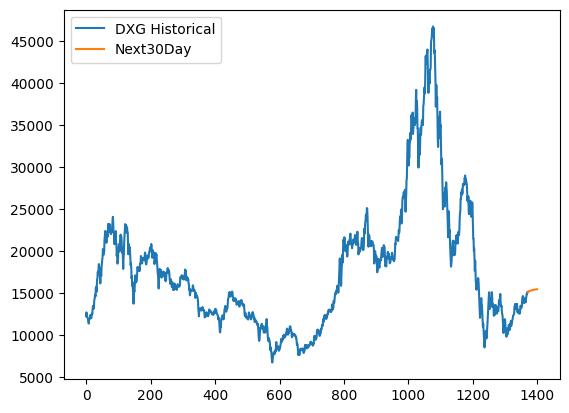

In [25]:
plt.plot(df.index, df.values)
plt.plot(last_data,y_next_30_days)
plt.legend(['DXG Historical', 'Next30Day'])
plt.show()